## GPy Example
https://github.com/SheffieldML/notebook/blob/master/GPy/coregionalized_regression_tutorial.ipynb

In [ ]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import scipy as sp
import theano.tensor as tt
import matplotlib.pylab as plt

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


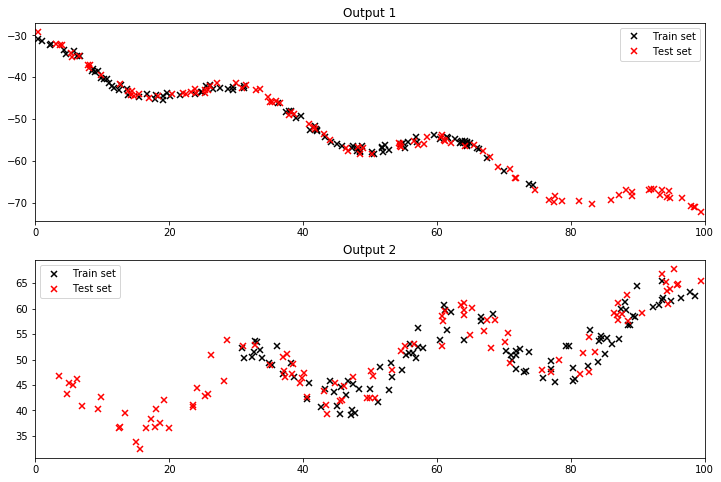

In [1]:
# This functions generate data corresponding to two outputs
def f_output1(x):
    return 4. * np.cos(x/5.) - .4*x - 35. + np.random.rand(x.size)[:, None] * 2.


def f_output2(x):
    return 6. * np.cos(x/5.) + .2*x + 35. + np.random.rand(x.size)[:, None] * 8.


#{X,Y} training set for each output
X1 = np.random.rand(100)[:, None]
X1 = X1*75
X2 = np.random.rand(100)[:, None]
X2 = X2*70 + 30
Y1 = f_output1(X1)
Y2 = f_output2(X2)
#{X,Y} test set for each output
Xt1 = np.random.rand(100)[:, None]*100
Xt2 = np.random.rand(100)[:, None]*100
Yt1 = f_output1(Xt1)
Yt2 = f_output2(Xt2)

xlim = (0, 100)
ylim = (0, 50)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
ax1.set_xlim(xlim)
ax1.set_title('Output 1')
ax1.plot(X1[:, :1], Y1, 'kx', mew=1.5, label='Train set')
ax1.plot(Xt1[:, :1], Yt1, 'rx', mew=1.5, label='Test set')
ax1.legend()
ax2 = fig.add_subplot(212)
ax2.set_xlim(xlim)
ax2.set_title('Output 2')
ax2.plot(X2[:, :1], Y2, 'kx', mew=1.5, label='Train set')
ax2.plot(Xt2[:, :1], Yt2, 'rx', mew=1.5, label='Test set')
ax2.legend()

In [9]:
def plot_2outputs(m, xlim, ylim):
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    # Output 1
    ax[0].set_xlim(xlim)
    ax[0].set_title('Output 1')
    m.plot(plot_limits=xlim, fixed_inputs=[
           (1, 0)], which_data_rows=slice(0, 100), ax=ax[0])
    ax[0].plot(Xt1[:, :1], Yt1, 'rx', mew=1.5)
    # Output 2
    ax[1].set_xlim(xlim)
    ax[1].set_title('Output 2')
    m.plot(plot_limits=xlim, fixed_inputs=[
           (1, 1)], which_data_rows=slice(100, 200), ax=ax[1])
    ax[1].plot(Xt2[:, :1], Yt2, 'rx', mew=1.5)

In [3]:
import GPy
K = GPy.kern.RBF(1)
B = GPy.kern.Coregionalize(input_dim=1, output_dim=2)
multkernel = K.prod(B, name='B.K')
print(multkernel)

  B_K.             |   value  |  constraints  |  priors
  rbf.variance     |     1.0  |      +ve      |        
  rbf.lengthscale  |     1.0  |      +ve      |        
  coregion.W       |  (2, 1)  |               |        
  coregion.kappa   |    (2,)  |      +ve      |        


In [4]:
# Components of B
print('W matrix\n', B.W)
print('\nkappa vector\n', B.kappa)
print('\nB matrix\n', B.B)

W matrix
   index  |  B_K.coregion.W  |  constraints  |  priors
  [0 0]  |     -0.74864234  |               |        
  [1 0]  |      1.09432059  |               |        

kappa vector
   index  |  B_K.coregion.kappa  |  constraints  |  priors
  [0]    |          0.50000000  |      +ve      |        
  [1]    |          0.50000000  |      +ve      |        

B matrix
 [[ 1.06046535 -0.81925472]
 [-0.81925472  1.69753755]]


In [5]:
icm = GPy.util.multioutput.ICM(
    input_dim=1, num_outputs=2, kernel=GPy.kern.RBF(1))
print(icm)

  ICM.             |   value  |  constraints  |  priors
  rbf.variance     |     1.0  |      +ve      |        
  rbf.lengthscale  |     1.0  |      +ve      |        
  B.W              |  (2, 1)  |               |        
  B.kappa          |    (2,)  |      +ve      |        



Name : gp
Objective : 368.58760152564946
Number of Parameters : 8
Number of Optimization Parameters : 7
Updates : True
Parameters:
  gp.                                    |               value  |  constraints  |  priors
  ICM.Mat32.variance                     |                 1.0  |   fixed +ve   |        
  ICM.Mat32.lengthscale                  |  217.18311167277756  |      +ve      |        
  ICM.B.W                                |              (2, 1)  |               |        
  ICM.B.kappa                            |                (2,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |  0.2913447031646442  |      +ve      |        
  mixed_noise.Gaussian_noise_1.variance  |   5.261194089332092  |      +ve      |        


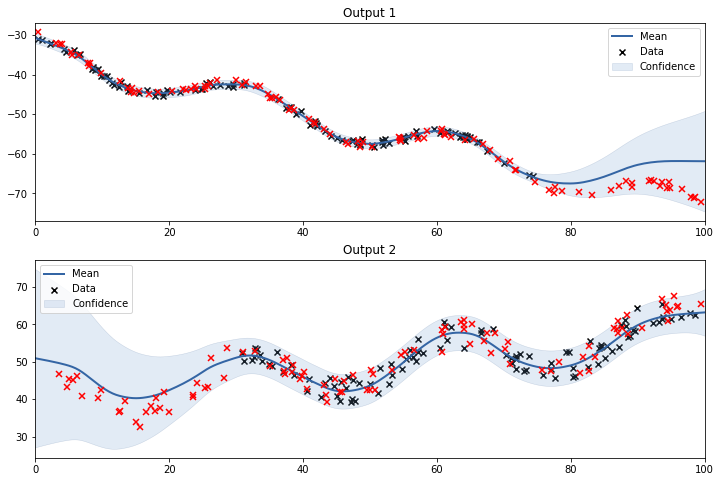

In [10]:
K = GPy.kern.Matern32(1)
icm = GPy.util.multioutput.ICM(input_dim=1, num_outputs=2, kernel=K)

m = GPy.models.GPCoregionalizedRegression([X1, X2], [Y1, Y2], kernel=icm)
# For this kernel, B.kappa encodes the variance now.
m['.*Mat32.var'].constrain_fixed(1.)
m.optimize()
print(m)
plot_2outputs(m, xlim=(0, 100), ylim=(-20, 60))

## Coregional GP regression in PyMC3

In [13]:
help(pm.gp.MarginalKron)

Help on class MarginalKron in module pymc3.gp.gp:

class MarginalKron(Base)
 |  Marginal Gaussian process whose covariance is a tensor product kernel.
 |  
 |  The `gp.MarginalKron` class is an implementation of the sum of a Kronecker
 |  GP prior and additive white noise. It has `marginal_likelihood`,
 |  `conditional` and `predict` methods. This GP implementation can be used to
 |  efficiently implement regression on data that are normally distributed with
 |  a tensor product kernel and are measured on a full grid of inputs:
 |  `cartesian(*Xs)`. `MarginalKron` is based on the `KroneckerNormal`
 |  distribution, see its docstring for more information. For more information
 |  on the `prior` and `conditional` methods, see their docstrings.
 |  
 |  Parameters
 |  ----------
 |  cov_funcs : list of Covariance objects
 |      The covariance functions that compose the tensor (Kronecker) product.
 |      Defaults to [zero].
 |  mean_func : None, instance of Mean
 |      The mean function

In [3]:
with pm.Model() as model:
    ℓ = pm.HalfCauchy("ℓ", beta=2.5)
    
    η1 = pm.HalfCauchy("η1", beta=2.5)
    cov1 = η1**2 * pm.gp.cov.Matern52(1, ℓ)
    gp1 = pm.gp.Marginal(cov_func=cov1)
    σ1 = pm.HalfNormal("σ1", sd=1.)
    y1_ = gp1.marginal_likelihood("y1", X=X1, y=Y1.flatten(), noise=σ1)
#     trace = pm.sample(1000, njobs=4, tune=1000, init='advi+adapt_diag')
    mp = pm.find_MAP()

logp = -135.48, ||grad|| = 4.4658: 100%|██████████| 18/18 [00:00<00:00, 183.31it/s]


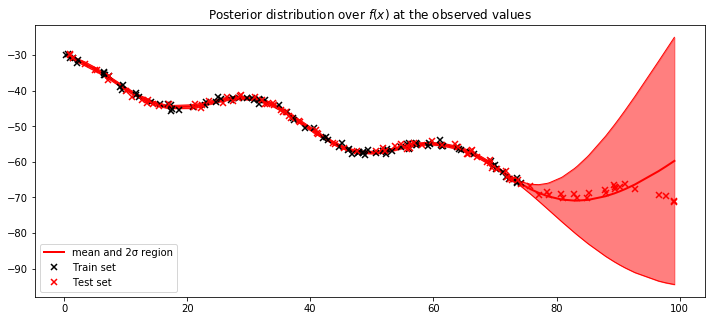

In [23]:
# predict
X_new = np.sort(Xt1,axis=0)
mu, var = gp1.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(X_new, mu + 2*sd, 'r', lw=1); plt.plot(X_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot the data and the true latent function
plt.plot(X1[:,:1],Y1,'kx',mew=1.5,label='Train set')
plt.plot(Xt1[:,:1],Yt1,'rx',mew=1.5,label='Test set')

plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...
Average Loss = 397.11:   6%|▋         | 12999/200000 [06:03<1:17:52, 40.02it/s]
Convergence archived at 13000
INFO:pymc3.variational.inference:Convergence archived at 13000
Interrupted at 12,999 [6%]: Average Loss = 1,805.2
INFO:pymc3.variational.inference:Interrupted at 12,999 [6%]: Average Loss = 1,805.2
100%|██████████| 2000/2000 [21:14<00:00,  3.88it/s]


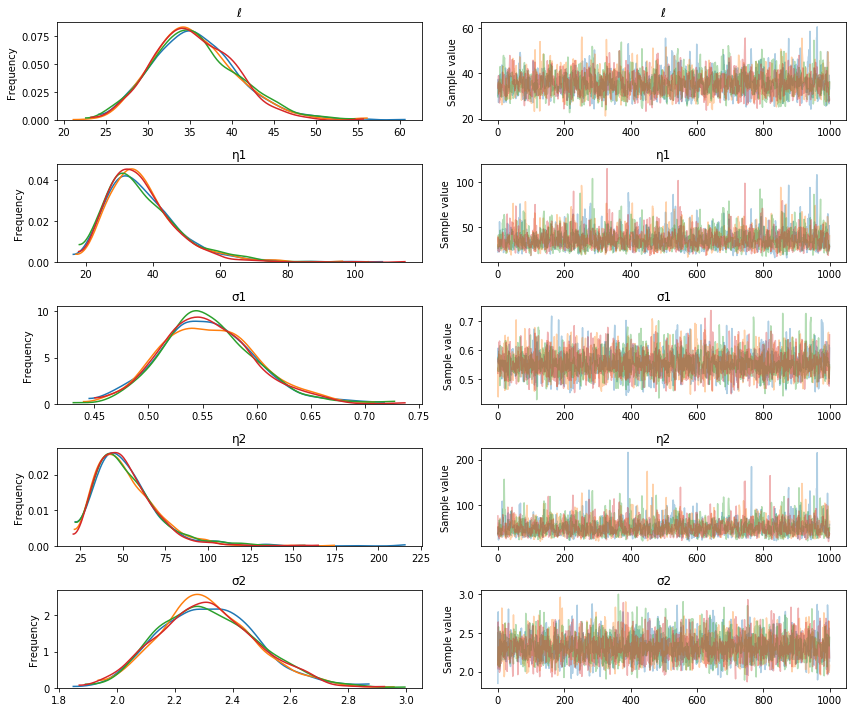

In [29]:
with pm.Model() as model:
    ℓ = pm.HalfCauchy("ℓ", beta=2.5)
    
    η1 = pm.HalfCauchy("η1", beta=2.5)
    cov1 = η1**2 * pm.gp.cov.Matern52(1, ℓ)
    gp1 = pm.gp.Marginal(cov_func=cov1)
    σ1 = pm.HalfNormal("σ1", sd=1.)
    y1_ = gp1.marginal_likelihood("y1", X=X1, y=Y1.flatten(), noise=σ1)
    
    η2 = pm.HalfCauchy("η2", beta=2.5)
    cov2 = η2**2 * pm.gp.cov.Matern52(1, ℓ)
    gp2 = pm.gp.Marginal(cov_func=cov2)
    σ2 = pm.HalfNormal("σ2", sd=1.)
    y2_ = gp2.marginal_likelihood("y2", X=X2, y=Y2.flatten(), noise=σ2)

    trace = pm.sample(1000, njobs=4, tune=1000, init='advi+adapt_diag')
    pm.traceplot(trace);

#     trace=pm.find_MAP()
# trace

In [32]:
# add the GP conditional to the model, given the new X values
with model:
    f_pred1 = gp1.conditional("f_pred1", np.sort(Xt1,axis=0))
    f_pred2 = gp2.conditional("f_pred2", np.sort(Xt2,axis=0))
    pred_samples = pm.sample_ppc(trace, vars=[f_pred1, f_pred2], samples=100)

100%|██████████| 100/100 [00:05<00:00, 17.11it/s]


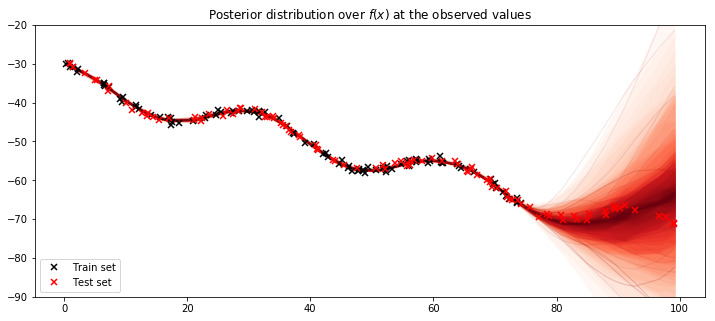

In [36]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred1"], np.sort(Xt1,axis=0));

# plot the data and the true latent function
plt.plot(X1[:,:1],Y1,'kx',mew=1.5,label='Train set')
plt.plot(Xt1[:,:1],Yt1,'rx',mew=1.5,label='Test set')

plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.ylim([-90,-20])
plt.legend();

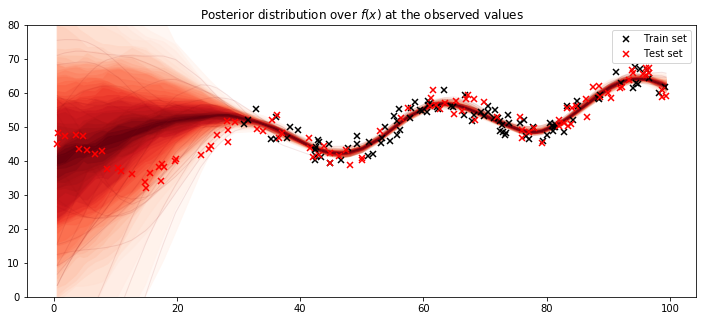

In [37]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred2"], np.sort(Xt2,axis=0));

# plot the data and the true latent function
plt.plot(X2[:,:1],Y2,'kx',mew=1.5,label='Train set')
plt.plot(Xt2[:,:1],Yt2,'rx',mew=1.5,label='Test set')

plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.ylim([0, 80])
plt.legend();

In [ ]:
n=Y1.shape[0]
with pm.Model() as model:
    # priors on the covariance function hyperparameters
    l = pm.HalfCauchy('l', beta=3) 
    # prior on the function variance
    s2_f = pm.HalfCauchy('s2_f', beta=2)
    # prior on the noise variance
    s2_n = pm.HalfCauchy('s2_n', beta=2)
    # covariance functions for the function f and the noise
    f_cov = s2_f * pm.gp.cov.ExpQuad(1, l)
    # pm.gp.GP does the following internally
    Sigma2 = f_cov(X2) + tt.eye(n)*s2_n**2
    y_obs = pm.MvNormal('y_obs', mu=np.zeros(n), cov=Sigma2, observed=Y2.flatten())
    trace = pm.sample(1000, njobs=4)
    
pm.traceplot(trace);

In [ ]:
n=Y1.shape[0]
with pm.Model() as model:
    # priors on the covariance function hyperparameters
    l = pm.HalfCauchy('l', beta=3) 
    # prior on the function variance
    s2_f = pm.HalfCauchy('s2_f', beta=2)
    # prior on the noise variance
    s2_n = pm.HalfCauchy('s2_n', beta=2)
    # covariance functions for the function f and the noise
    f_cov = s2_f * pm.gp.cov.M(1, l)
    # pm.gp.GP does the following internally
    Sigma1 = f_cov(X1) + tt.eye(n)*s2_n**2
    y_obs1 = pm.MvNormal('y_obs1', mu=np.zeros(n), cov=Sigma1, observed=Y1.flatten())
    Sigma2 = f_cov(X2) + tt.eye(n)*s2_n**2
    y_obs2 = pm.MvNormal('y_obs2', mu=np.zeros(n), cov=Sigma2, observed=Y2.flatten())
    trace = pm.sample(1000, njobs=4)
    
pm.traceplot(trace);